In [44]:
!pip install timm

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: flatbuffers 1.12.1-git20200711.33e2d80-dfsg1-0.6 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of flatbuffers or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [45]:
import timm
import torch
import copy
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix
from torchvision import transforms, datasets


In [46]:
print(timm.__version__)
print(torch.__version__)

0.9.16
2.0.1


In [47]:
def create_vit(model_name):
    if model_name == 'tiny': model = timm.create_model('vit_tiny_patch16_224', pretrained=False, num_classes=4)
    if model_name == 'small': model = timm.create_model('vit_small_patch16_224', pretrained=False, num_classes=4)
    if model_name == 'base': model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=4)

    return model

In [48]:
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

dataset = datasets.ImageFolder(root='/home/ubuntu/Parkinson-Project/non-keyframes/energy_images', transform=transform)

total_size = len(dataset)
train_size = int(total_size * 0.8) 
validation_size = int(total_size * 0.1) 
test_size = total_size - train_size - validation_size
generator = torch.Generator().manual_seed(0) 
train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size], generator=generator)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [49]:
experiment = 'vit-tiny-130-epochs-early-stopping'

In [50]:
model_type = 'tiny'
model = create_vit(model_type)

# Model summary to check architecture
print(model)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()


In [51]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

In [52]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

num_epochs = 130  
patience = 20  
best_val_loss = float('inf')  
best_model = None  

train_loss_list = list()
val_loss_list = list()
train_accuracy_list = list()
val_accuracy_list = list()

for epoch in range(num_epochs):
    model.train() 
    running_loss = 0.0
    correct = 0
    total = 0
    print(f"Epoch {epoch+1}")

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)  

        optimizer.zero_grad()  
        outputs = model(images)  
        loss = criterion(outputs, labels)  
        loss.backward() 
        optimizer.step() 

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        print(f"Batch {batch_idx+1}, Loss: {loss.item():.6f}, Accuracy: {100 * correct / total:.2f}%")

    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    print(f"Training - Epoch {epoch+1}, Loss: {train_loss:.6f}, Accuracy: {train_accuracy:.2f}%")

    # Validation step
    model.eval()  
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():  
        for batch_idx, (images, labels) in enumerate(val_loader):
            images, labels = images.to(device), labels.to(device)  

            outputs = model(images) 
            loss = criterion(outputs, labels) 

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            print(f"Validation Batch {batch_idx+1}, Loss: {loss.item():.6f}, Accuracy: {100 * val_correct / val_total:.2f}%")

    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_accuracy)

    val_loss /= len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    print(f"Validation - Epoch {epoch+1}, Loss: {val_loss:.6f}, Accuracy: {val_accuracy:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
        patience_counter = 0
    else:
        patience_counter += 1

    print(f'Patience—{patience_counter}')

    # Check for early stopping
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

model = best_model
torch.save(model.state_dict(), f'{experiment}-{model_type}')

Using device: cuda:0
Epoch 1
Batch 1, Loss: 1.408022, Accuracy: 18.75%
Batch 2, Loss: 1.514790, Accuracy: 27.34%
Batch 3, Loss: 1.423060, Accuracy: 28.12%
Batch 4, Loss: 1.287449, Accuracy: 30.86%
Batch 5, Loss: 1.372656, Accuracy: 30.31%
Batch 6, Loss: 1.214050, Accuracy: 31.51%
Batch 7, Loss: 1.265800, Accuracy: 30.58%
Batch 8, Loss: 1.267545, Accuracy: 29.10%
Batch 9, Loss: 1.325170, Accuracy: 30.21%
Batch 10, Loss: 1.353290, Accuracy: 30.16%
Batch 11, Loss: 1.234784, Accuracy: 30.40%
Batch 12, Loss: 1.351267, Accuracy: 30.99%
Batch 13, Loss: 1.265854, Accuracy: 31.01%
Batch 14, Loss: 1.321154, Accuracy: 30.92%
Batch 15, Loss: 1.214875, Accuracy: 31.25%
Batch 16, Loss: 1.309605, Accuracy: 31.35%
Batch 17, Loss: 1.359040, Accuracy: 31.25%
Batch 18, Loss: 1.295241, Accuracy: 31.68%
Batch 19, Loss: 1.264220, Accuracy: 31.91%
Batch 20, Loss: 1.316950, Accuracy: 32.11%
Batch 21, Loss: 1.427047, Accuracy: 31.47%
Batch 22, Loss: 1.228476, Accuracy: 31.68%
Batch 23, Loss: 1.234161, Accuracy

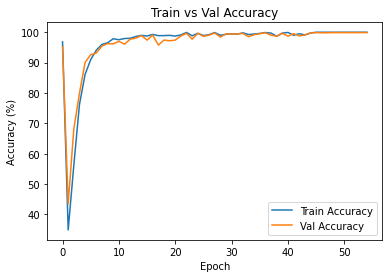

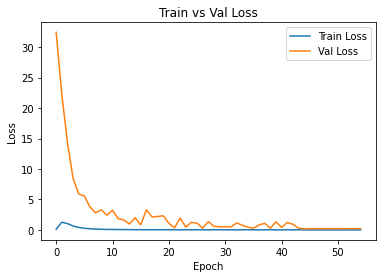

In [53]:
import matplotlib.pyplot as plt

plt.plot(train_accuracy_list, label='Train Accuracy')

# Plotting the second graph
plt.plot(val_accuracy_list, label='Val Accuracy')

# Adding labels and a legend
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train vs Val Accuracy')
plt.legend()

# Display the plot
plt.show()

plt.plot(train_loss_list, label='Train Loss')

# Plotting the second graph
plt.plot(val_loss_list, label='Val Loss')

# Adding labels and a legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Val Loss')
plt.legend()

# Display the plot
plt.show()

In [54]:
model.eval()

test_loss = 0.0
test_correct = 0
test_total = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        print(f"Test Batch {batch_idx+1}, Loss: {loss.item():.6f}, Accuracy: {100 * test_correct / test_total:.2f}%")

test_loss /= len(test_loader)
test_accuracy = 100 * test_correct / test_total

print(f"Test Set - Loss: {test_loss:.6f}, Accuracy: {test_accuracy:.2f}%")

cm = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(cm)

Test Batch 1, Loss: 0.000794, Accuracy: 100.00%
Test Batch 2, Loss: 0.001584, Accuracy: 100.00%
Test Batch 3, Loss: 0.000500, Accuracy: 100.00%


Test Batch 4, Loss: 0.000658, Accuracy: 100.00%
Test Batch 5, Loss: 0.000561, Accuracy: 100.00%
Test Batch 6, Loss: 0.079773, Accuracy: 99.74%
Test Batch 7, Loss: 0.000403, Accuracy: 99.78%
Test Batch 8, Loss: 0.000527, Accuracy: 99.80%
Test Batch 9, Loss: 0.001967, Accuracy: 99.83%
Test Batch 10, Loss: 0.000567, Accuracy: 99.84%
Test Batch 11, Loss: 0.008066, Accuracy: 99.86%
Test Batch 12, Loss: 0.039644, Accuracy: 99.74%
Test Batch 13, Loss: 0.001194, Accuracy: 99.76%
Test Batch 14, Loss: 0.000630, Accuracy: 99.78%
Test Batch 15, Loss: 0.000483, Accuracy: 99.79%
Test Batch 16, Loss: 0.000680, Accuracy: 99.80%
Test Batch 17, Loss: 0.002303, Accuracy: 99.82%
Test Batch 18, Loss: 0.000535, Accuracy: 99.83%
Test Batch 19, Loss: 0.000507, Accuracy: 99.84%
Test Batch 20, Loss: 0.000484, Accuracy: 99.84%
Test Batch 21, Loss: 0.000678, Accuracy: 99.85%
Test Batch 22, Loss: 0.000489, Accuracy: 99.86%
Test Batch 23, Loss: 0.153426, Accuracy: 99.80%
Test Batch 24, Loss: 0.137874, Accuracy: 99.

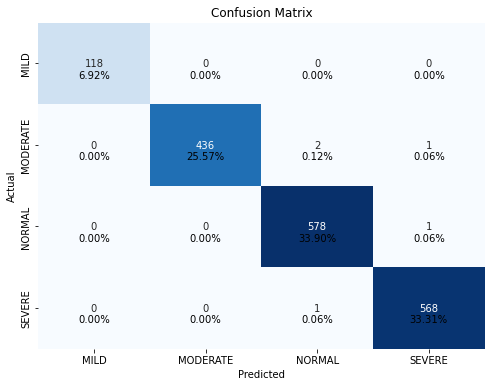

Accuracy: 1.00


: 

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

cm = confusion_matrix(all_labels, all_predictions)

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_predictions)

# Calculate percentages for each element
cm_percentage = (cm / np.sum(cm)) * 100

# Plot confusion matrix with count and percentages
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['MILD', 'MODERATE', 'NORMAL', 'SEVERE'],
            yticklabels=['MILD', 'MODERATE', 'NORMAL', 'SEVERE'],
            ax=ax)

# Annotate each box with count and percentage
for i in range(len(cm)):
    for j in range(len(cm[0])):
        ax.text(j + 0.5, i + 0.5, f'\n\n{cm_percentage[i, j]:.2f}%',
                ha='center', va='center', color='black')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(f'Accuracy: {accuracy:.2f}')

Early Stopping at Epoch 55
Test Accuracy — 99.71%